In [1]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import sys
from tqdm import tqdm
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
from hcr import * 

Initializing transcriptomics package
Initializing plotting package
Initializing HCR package


In [2]:
# Load genome
genome_fasta_path = '../raw-data/OBir/genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

In [3]:
# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

In [4]:
object_name = "../raw-data/OBir/transcriptome/biroi_transcriptome"
tr = load_transcriptome_object(object_name)

In [5]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.gene_biotype == 'lncRNA']
len(all_lncRNAs), len(all_genes)

(1423, 13810)

In [6]:
# iterate through each row of or_db 
for i, row in or_db.iterrows(): 
    gene = tr.get_gene(row.gene_name) 
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    or_db.at[i,'start'] = bounds[0]
    or_db.at[i,'end'] = bounds[1] 
    or_db.at[i,'strand'] = transcript.strand 
    or_db.at[i, 'chr'] = transcript.chromosome
    or_db.at[i, 'chr_num'] = int(transcript.chromosome.split('r')[1])
    or_db.at[i,'n_exons'] = len(transcript.exons)
    or_db.at[i,'nine_exon'] = "9E" in row['gene_name']
    or_db.at[i,'ta_size'] = or_db.loc[or_db.tandem_array == row['tandem_array']].shape[0]
or_db['start'] = or_db['start'].astype(int)
or_db['end'] = or_db['end'].astype(int)
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db['ta_index'] = or_db.groupby('tandem_array')['start'].rank(method='first', ascending=True).astype(int)

or_db.head(5)

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,chr_num,n_exons,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',6504395,6510987,-,Chr1,1.0,8.0,False,2,1
1,1,Or5-Q1,70,2,5',6511625,6514800,-,Chr1,1.0,7.0,False,2,2
2,1,Or5-Orco,72,3,NaN,10910490,10919026,+,Chr1,1.0,9.0,False,2,1
3,1,Or5-Q2,72,4,NaN,10934666,10938750,+,Chr1,1.0,6.0,False,2,2
4,1,Or5-9E1,73,5,NaN,10980671,10984094,+,Chr1,1.0,6.0,True,1,1


In [7]:
# Sort by chromosome and start position
or_db = or_db.sort_values(['chr_num', 'start']).reset_index(drop=True)
or_db

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,chr_num,n_exons,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',6504395,6510987,-,Chr1,1.0,8.0,False,2,1
1,1,Or5-Q1,70,2,5',6511625,6514800,-,Chr1,1.0,7.0,False,2,2
2,1,Or5-Orco,72,3,NaN,10910490,10919026,+,Chr1,1.0,9.0,False,2,1
3,1,Or5-Q2,72,4,NaN,10934666,10938750,+,Chr1,1.0,6.0,False,2,2
4,1,Or5-9E1,73,5,NaN,10980671,10984094,+,Chr1,1.0,6.0,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,12,Or5-L35,3,498,3',8808087,8810716,+,Chr12,12.0,7.0,False,32,32
498,12,Or5-9E350,5,499,NaN,12304523,12308947,+,Chr12,12.0,8.0,True,1,1
499,12,Or5-9E351,6,500,NaN,13227042,13237610,-,Chr12,12.0,9.0,True,1,1
500,12,Or5-9Efrag3,7,501,NaN,13617769,13619604,-,Chr12,12.0,3.0,True,1,1


In [8]:
def overlapping(chr1, start1, end1, chr2, start2, end2): 
    if chr1 != chr2: 
        return False
    if start1 > end2 or start2 > end1: 
        return False
    return True

In [9]:
# Find nested and antisense lncRNAs within TAs 
TAs = or_db['tandem_array'].unique()
ta_lncRNAs = [] 

for TA in TAs: 
    # Get bounds of tandem array 
    TA_genes = or_db.loc[or_db['tandem_array'] == int(TA)]
    TA_chromosome = TA_genes.iloc[0].chr
    TA_bounds = (TA_genes.iloc[0].start, TA_genes.iloc[-1].end)

    # Get most common strand (remember these are strings) 
    TA_strands = TA_genes.strand.values 
    TA_strand = max(set(TA_strands), key = list(TA_strands).count)
    
    for lncRNA in all_lncRNAs: 
        transcript = lncRNA.get_transcript_longest_bounds()
        lnc_bounds = transcript.get_bounds()
        if lncRNA.strand == TA_strand:
            continue 
        # Check if lncRNA is overlapping with TA
        if not overlapping(TA_chromosome, TA_bounds[0], TA_bounds[1], lncRNA.chromosome, lnc_bounds[0], lnc_bounds[1]):
            continue
        
        # Save 
        ta_lncRNAs.append({'gene_name': lncRNA.name, 
                                'tandem_array': TA, 
                                'lncRNA_transcript': transcript.name,
                                'TA_location': f"{TA_chromosome}:{TA_bounds[0]}-{TA_bounds[1]}", 
                                'TA_size': TA_bounds[1] - TA_bounds[0],
                                'lncRNA_location': f"{lncRNA.chromosome}:{lnc_bounds[0]}-{lnc_bounds[1]}", 
                                'chr': lncRNA.chromosome,
                                'lncRNA_start': lnc_bounds[0],
                                'lncRNA_end': lnc_bounds[1],
                                'lncRNA_strand': lncRNA.strand, 
                                'TA_strand': TA_strand,
                                'lncRNA_rel_strand' : "sense" if lncRNA.strand == TA_strand else "antisense",
                                'lncRNA_size': lnc_bounds[1] - lnc_bounds[0]})

ta_lncRNAs = pd.DataFrame(ta_lncRNAs)
ta_lncRNAs

,gene_name,tandem_array,lncRNA_transcript,TA_location,TA_size,lncRNA_location,chr,lncRNA_start,lncRNA_end,lncRNA_strand,TA_strand,lncRNA_rel_strand,lncRNA_size
0,LOC105284782,72,XR_894925.1,Chr1:10910490-10938750,28260,Chr1:10932104-10933972,Chr1,10932104,10933972,-,+,antisense,1868
1,LOC113562279,80,XR_003406783.1,Chr1:18401037-18422446,21409,Chr1:18415710-18417312,Chr1,18415710,18417312,+,-,antisense,1602
2,LOC105281803,56,XR_003407557.1,Chr2:2457195-2491432,34237,Chr2:2477097-2480203,Chr2,2477097,2480203,+,-,antisense,3106
3,LOC109611010,62,XR_003406184.1,Chr2:16359674-16554585,194911,Chr2:16521651-16522364,Chr2,16521651,16522364,+,-,antisense,713
4,LOC109611013,62,XR_002193330.1,Chr2:16359674-16554585,194911,Chr2:16482234-16482788,Chr2,16482234,16482788,+,-,antisense,554
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,LOC105275250,10,XR_893213.2,Chr11:12234278-12251405,17127,Chr11:12237414-12237785,Chr11,12237414,12237785,-,+,antisense,371
77,LOC105281874,3,XR_894384.3,Chr12:8696505-8810716,114211,Chr12:8736692-8736982,Chr12,8736692,8736982,-,+,antisense,290
78,LOC105284280,3,XR_002193640.2,Chr12:8696505-8810716,114211,Chr12:8697329-8699194,Chr12,8697329,8699194,-,+,antisense,1865
79,LOC109611157,3,XR_002193506.2,Chr12:8696505-8810716,114211,Chr12:8807488-8808023,Chr12,8807488,8808023,-,+,antisense,535


In [10]:
def calculate_overlap(chr1, start1, end1, chr2, start2, end2): 
    if not overlapping(chr1, start1, end1, chr2, start2, end2): 
        return 0
    overlap = min(end1, end2) - max(start1, start2)
    return overlap

In [11]:
# Calculate the percentage of OR gene regions that are overlapped by lncRNAs
for i, row in or_db.iterrows(): 
    # Get the length of the OR (longest transcript)
    or_db.at[i, 'or_len'] = row.end - row.start 
    # Get relevant lncRNAs (those that are overlappign with the same TA)
    relevant_lncRNAs = ta_lncRNAs.loc[ta_lncRNAs.tandem_array == row.tandem_array].copy()
    # Check whether there are any rows 
    if relevant_lncRNAs.shape[0] == 0: 
        or_db.at[i, 'max_lnc_overlap'] = 0
        or_db.at[i, 'overlap_percent'] = 0
        continue
    # Calculate the overlap with each lncRNA
    relevant_lncRNAs['overlap'] = relevant_lncRNAs.apply(lambda x: calculate_overlap(row.chr, row.start, row.end, x.chr, x.lncRNA_start, x.lncRNA_end), axis=1)
    # Get the maximum overlap with any lncRNA 
    or_db.at[i, 'max_lnc_overlap'] = relevant_lncRNAs.overlap.max()
    # Get the percentage of the OR gene that is overlapped by lncRNAs
    or_db.at[i, 'overlap_percent'] = or_db.at[i, 'max_lnc_overlap'] / or_db.at[i, 'or_len']

or_db

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,chr_num,n_exons,nine_exon,ta_size,ta_index,or_len,max_lnc_overlap,overlap_percent
0,1,Or5-R2,70,1,3',6504395,6510987,-,Chr1,1.0,8.0,False,2,1,6592.0,0.0,0.0
1,1,Or5-Q1,70,2,5',6511625,6514800,-,Chr1,1.0,7.0,False,2,2,3175.0,0.0,0.0
2,1,Or5-Orco,72,3,NaN,10910490,10919026,+,Chr1,1.0,9.0,False,2,1,8536.0,0.0,0.0
3,1,Or5-Q2,72,4,NaN,10934666,10938750,+,Chr1,1.0,6.0,False,2,2,4084.0,0.0,0.0
4,1,Or5-9E1,73,5,NaN,10980671,10984094,+,Chr1,1.0,6.0,True,1,1,3423.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,12,Or5-L35,3,498,3',8808087,8810716,+,Chr12,12.0,7.0,False,32,32,2629.0,0.0,0.0
498,12,Or5-9E350,5,499,NaN,12304523,12308947,+,Chr12,12.0,8.0,True,1,1,4424.0,0.0,0.0
499,12,Or5-9E351,6,500,NaN,13227042,13237610,-,Chr12,12.0,9.0,True,1,1,10568.0,0.0,0.0
500,12,Or5-9Efrag3,7,501,NaN,13617769,13619604,-,Chr12,12.0,3.0,True,1,1,1835.0,0.0,0.0


In [12]:
# what percentage of ORs overlap with lncRNAs at all? 
or_db.loc[or_db.overlap_percent > 0].shape[0] / or_db.shape[0]

0.27091633466135456

In [13]:
# Sample all random non-OR genes 
n_genes = 5000 
np.random.seed(0)
non_or_genes = [gene for gene in all_genes if "Or5" not in gene.name]
print(f"Identified {len(non_or_genes)} non-OR genes")

Identified 13237 non-OR genes


In [14]:
# Find overlapping antisense lncRNAs for each non-OR gene
non_or_lnc_overlap = [] 

for gene in tqdm(non_or_genes, total = len(non_or_genes)): 
    gene_bounds = gene.get_transcript_longest_bounds().get_bounds()
    gene_length = gene_bounds[1] - gene_bounds[0]
    
    relevant_lncRNAs = [] 
    for lncRNA in all_lncRNAs: 
        transcript = lncRNA.get_transcript_longest_bounds()
        lnc_bounds = transcript.get_bounds()
        if lncRNA.strand == gene.strand:
            continue 
        # Check if lncRNA is overlapping with TA
        if overlapping(gene.chromosome, gene_bounds[0], gene_bounds[1], lncRNA.chromosome, lnc_bounds[0], lnc_bounds[1]):
            relevant_lncRNAs.append(lncRNA) 

    if len(relevant_lncRNAs) == 0:
        max_overlap = 0 
        overlap_percent = 0
        lnc_name = None 
    else:
        overlap_with_gene = [calculate_overlap(gene.chromosome, gene_bounds[0], gene_bounds[1], lncRNA.chromosome, lncRNA.get_transcript_longest_bounds().get_bounds()[0], lncRNA.get_transcript_longest_bounds().get_bounds()[1]) for lncRNA in relevant_lncRNAs]
        max_overlap = max(overlap_with_gene)
        overlap_percent = max_overlap / gene_length
        lnc_name = relevant_lncRNAs[np.argmax(overlap_with_gene)].name
    
        
    # Save 
    non_or_lnc_overlap.append({'gene_name': gene.name, 
                        'lncRNA_name': lnc_name,
                        'chr': gene.chromosome,
                        'gene_start': gene_bounds[0],
                        'gene_end': gene_bounds[1],
                        'gene_strand': gene.strand,
                        'lncRNA_overlap': max_overlap,
                        'overlap_percent': overlap_percent})

non_or_lnc_overlap = pd.DataFrame(non_or_lnc_overlap)
non_or_lnc_overlap

100%|██████████| 13237/13237 [05:04<00:00, 43.43it/s]


,gene_name,lncRNA_name,chr,gene_start,gene_end,gene_strand,lncRNA_overlap,overlap_percent
0,CSP10.2,None,Chr13,1251897,1257450,+,0,0.0
1,Csp1,None,Chr10,2992852,2994140,-,0,0.0
2,Csp10,None,Chr13,1227032,1231037,+,0,0.0
3,Csp11,None,Chr10,8970673,8972214,+,0,0.0
4,Csp12,None,Chr5,13419564,13420947,+,0,0.0
...,...,...,...,...,...,...,...,...
13232,Trnay-gua_3,None,Chr8,9477506,9477604,+,0,0.0
13233,Trnay-gua_4,None,Chr8,9477679,9477777,+,0,0.0
13234,Trnay-gua_5,None,Chr8,9477853,9477951,+,0,0.0
13235,Trnay-gua_6,None,Chr8,9478429,9478525,+,0,0.0


In [15]:
non_or_lnc_overlap.loc[non_or_lnc_overlap['lncRNA_name'].notnull()]

,gene_name,lncRNA_name,chr,gene_start,gene_end,gene_strand,lncRNA_overlap,overlap_percent
14,Csp7,LOC105288191,Chr11,3113779,3119895,+,2528,0.413342
36,Gr3,LOC113562972,Chr11,12822816,12826335,+,1252,0.355783
44,Ir14,LOC113563047,Chr12,8163681,8168924,-,0,0.000000
52,Ir313,LOC113563047,Chr12,8158426,8161201,-,729,0.262703
68,Ir75u.2,LOC113561475,Chr2,15297299,15302080,-,240,0.050199
...,...,...,...,...,...,...,...,...
13147,Trnan-guu_4,LOC105276294,Chr9,2970795,2970868,+,73,1.000000
13166,Trnaq-cug_6,LOC105284183,Chr12,7120922,7120993,+,71,1.000000
13182,Trnar-ccu_1,LOC113562978,Chr11,10939176,10939248,-,72,1.000000
13204,Trnat-agu_1,LOC105276294,Chr9,2971284,2971357,+,73,1.000000


In [16]:
# what percentage of non-ORs overlap with lncRNAs at all? 
non_or_lnc_overlap.loc[non_or_lnc_overlap.overlap_percent > 0].shape[0] / non_or_lnc_overlap.shape[0]

0.05809473445644783

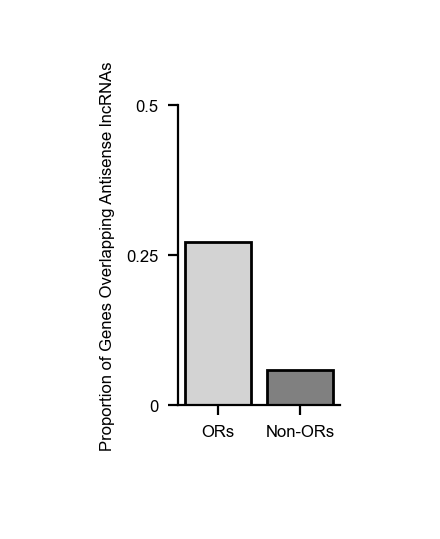

In [17]:
# Plot the proportion of ORs and non-ORs that overlap with lncRNAs 
f, ax = plt.subplots(1, 1, figsize = (1.5, 2), dpi=200) 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

or_overlap = or_db.loc[or_db.overlap_percent > 0].shape[0] / or_db.shape[0]
non_or_overlap = non_or_lnc_overlap.loc[non_or_lnc_overlap.overlap_percent > 0].shape[0] / non_or_lnc_overlap.shape[0]

ax.bar(['ORs', 'Non-ORs'], [or_overlap, non_or_overlap], color = ['lightgrey', 'grey'], lw=1, edgecolor = 'black')
ax.set_ylabel('Proportion of Genes Overlapping Antisense lncRNAs', fontsize=6)
ax.set_xticks([0, 1], labels=['ORs', 'Non-ORs'], fontsize=6)
ax.set_yticks([0, 0.25, 0.5], labels=[0, 0.25, 0.5], fontsize=6)

plt.tight_layout()
plt.savefig(f"../figures/lnc-overlap-stats.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)